# A dynamical system with `jax`

In this notebook, we will implement the Lotka-Volterra model with `jax` and try
to calibrate its parameters using gradient descent.


In [114]:
from functools import partial
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from flax import struct
from jax import random

from matplotlib.patches import Patch
from tqdm import tqdm

from macrocosm_visual.viz_setup import setup_matplotlib, setup_plotly
setup_matplotlib("./visual_configs.yaml")
setup_matplotlib("./visual_configs.yaml")

In [115]:
# Defining the Lotka-Volterra model


# First, we define a class to store the parameters of the model.
# In JAX, this is better done using flax.struct.dataclass.
# This is not very different from a regular Python class, but it can be
# used with jax.jit and jax.grad.
@struct.dataclass
class LotkaVolterraParams:
    """
    Parameters for the Lotka-Volterra model.

    alpha: Growth rate of prey
    beta: Predation rate
    gamma: Death rate of predators
    delta: Growth rate of predators
    """

    alpha: float
    beta: float
    gamma: float
    delta: float


def lotka_volterra(
    x0: float,
    y0: float,
    params: LotkaVolterraParams,
    dt: float = 0.01,
    n_steps: int = 100,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Solve the Lotka-Volterra ODEs using Euler's method.

    JAX implementation details:
    - Uses jax.lax.scan for efficient looping (avoids Python loops)
    - scan automatically handles the carry state and accumulates outputs
    - All operations use JAX arrays for automatic differentiation

    Args:
        x0, y0: Initial populations
        params: LotkaVolterraParams instance
        dt: Integration time step
        n_steps: Number of integration steps

    Returns:
        x, y: Time series arrays including initial conditions
    """

    def euler_step(state, _):
        """
        One step of the Euler method. We don't want to use anything fancy here.
        """
        x, y = state

        # Lotka-Volterra equations
        dx = dt * (params.alpha * x - params.beta * x * y)
        dy = dt * (params.delta * x * y - params.gamma * y)

        # Update state
        new_state = (x + dx, y + dy)

        # Return new state and the same state (for accumulation)
        return new_state, new_state

    initial_state = (x0, y0)

    # scan efficiently loops and accumulates results; much faster than a Python loop
    _, trajectory = jax.lax.scan(euler_step, initial_state, None, length=n_steps)

    # Unpack trajectory and prepend initial condition
    x_traj, y_traj = trajectory
    x = jnp.concatenate([jnp.array([x0]), x_traj])
    y = jnp.concatenate([jnp.array([y0]), y_traj])

    return x, y


def generate_data(
    x_0: float,
    y_0: float,
    true_params: dict,
    n_time_steps: int = 500,
    dt: float = 0.01,
):
    """
    Generate synthetic Lotka-Volterra population time series data (no noise).

    Simulates the prey and predator populations over time using the Lotka-Volterra equations
    and returns the trajectories.

    Args:
        x_0 (float): Initial prey population.
        y_0 (float): Initial predator population.
        true_params (dict): Dictionary of true Lotka-Volterra parameters (alpha, beta, gamma, delta).
        n_time_steps (int, optional): Number of time steps (default: 500).
        dt (float, optional): Integration time step (default: 0.01).

    Returns:
        dict: A dictionary containing:
            - 'observations' (jnp.ndarray): Observed populations, shape (2, n_time_steps + 1).
            - 'true_trajectory' (jnp.ndarray): True populations, shape (2, n_time_steps + 1).
            - 'time' (jnp.ndarray): Time points, shape (n_time_steps + 1,).
            - 'x_true' (jnp.ndarray): True prey population, shape (n_time_steps + 1,).
            - 'y_true' (jnp.ndarray): True predator population, shape (n_time_steps + 1,).
    """

    # Create JIT-compiled lotka_volterra with fixed dt and n_steps
    lotka_volterra_jit = jax.jit(partial(lotka_volterra, dt=dt, n_steps=n_time_steps))

    # Generate true Lotka-Volterra trajectory
    true_lv_params = LotkaVolterraParams(**true_params)
    x_true, y_true = lotka_volterra_jit(x_0, y_0, true_lv_params)

    # Create time array
    time = jnp.arange(n_time_steps + 1) * dt
    true_trajectory = jnp.stack([x_true, y_true], axis=0)

    return {
        "true_trajectory": true_trajectory,
        "time": time,
        "x_true": x_true,
        "y_true": y_true,
    }

In [116]:
# Generate data
# let's first define the true parameters!

true_params = dict(alpha=2 / 3, beta=4 / 3, gamma=1, delta=1)
x_0, y_0 = 1.5, 1.5
n_time_steps = 2_000

data = generate_data(x_0, y_0, true_params, n_time_steps)

/var/folders/wq/xmjtznvj5q37jt1txbvv2s9c0000gn/T/ipykernel_51705/1531465986.py:15: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



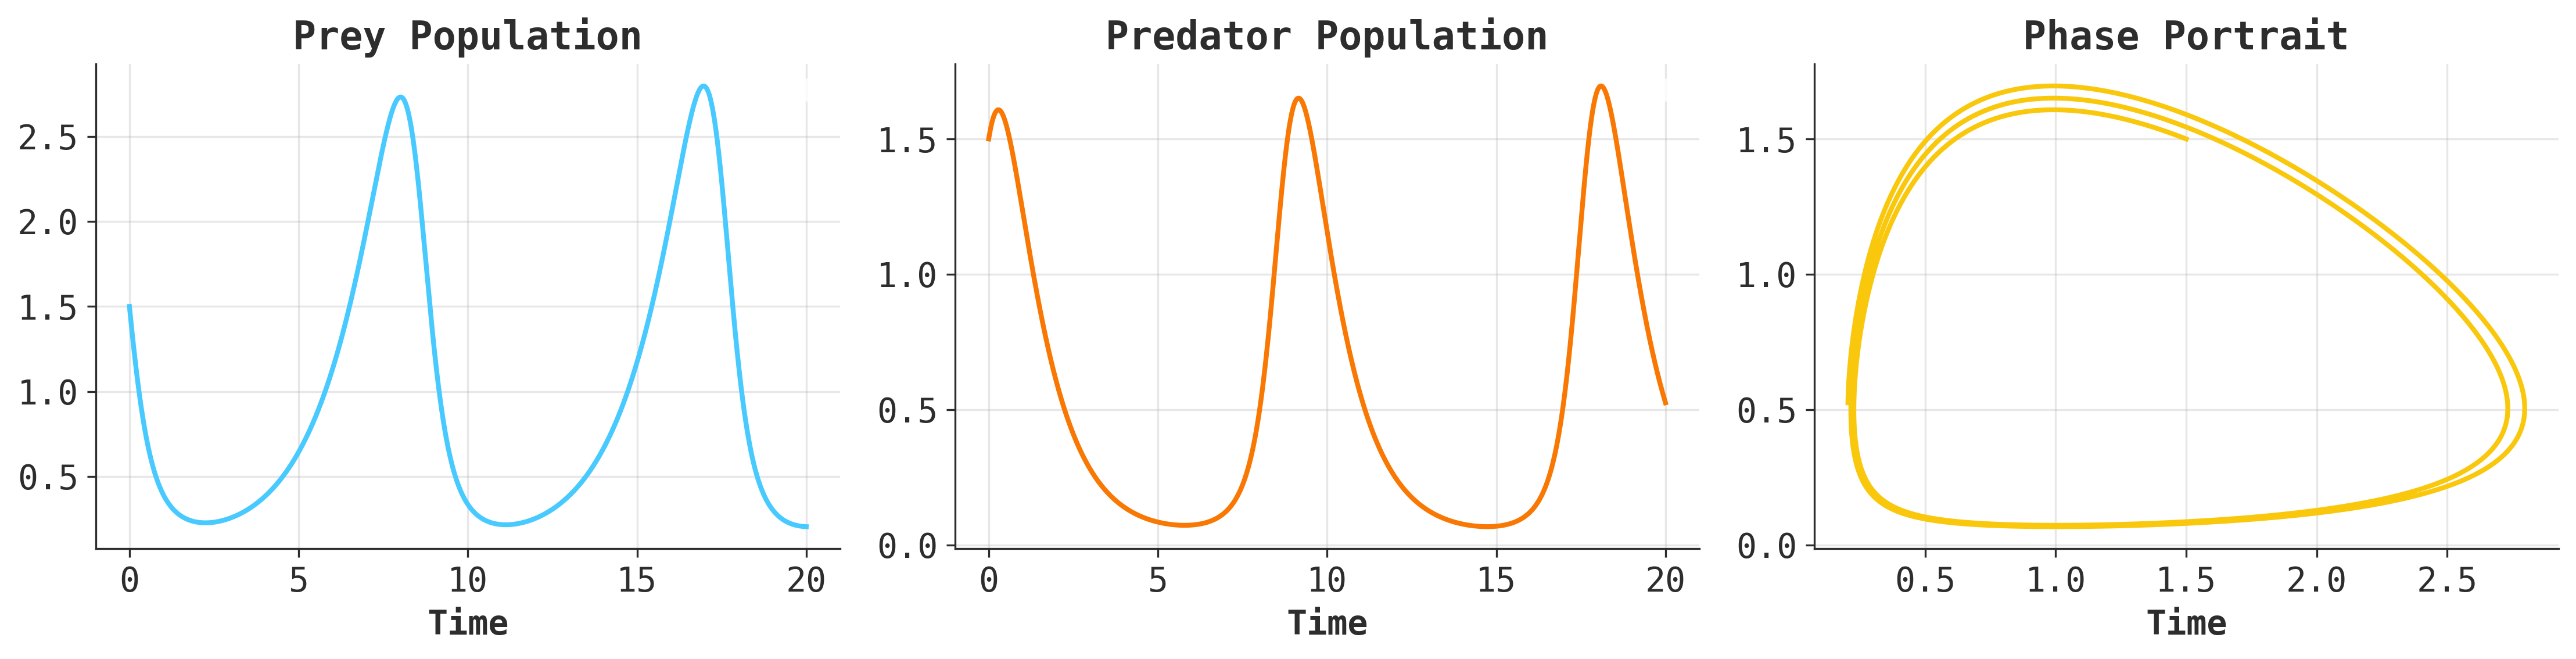

In [117]:
# ... and make a nice plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(data["time"], data["x_true"], "-", color="C0", linewidth=2)
axs[0].set_title("Prey Population")


axs[1].plot(data["time"], data["y_true"], "-", color="C1", linewidth=2)
axs[1].set_title("Predator Population")

axs[2].plot(data["x_true"], data["y_true"], "-", color="C3", linewidth=2)
axs[2].set_title("Phase Portrait")

for ax in axs:
    ax.legend()
    ax.set_xlabel("Time")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Calibrate the model

Imagine that now we have been given the data above, and are asked to estimate the parameters alpha, beta, gamma, and delta
of the Lotka-Volterra model.

We will use gradient descent to find the parameters that best fit the data.

In [118]:
# First, we need to define a loss function.
# We will take the squared error between the observed data and the model's prediction.

def loss_fn(predictions: jnp.ndarray, observations: jnp.ndarray) -> float:
    #return jnp.sum((predictions - observations) ** 2)
    # return jnp.sum((jnp.log(predictions) - jnp.log(observations)) ** 2)
    scale = jnp.std(observations) + 1e-6
    diff = (predictions - observations) / scale
    return jnp.mean(diff ** 2)

# Note that many losses are available by default in optax.losses;
# optax is an optimization library that is part of the JAX ecosystem.

# We want to compute the gradient of the loss function with respect to the parameters.
# Thus, we need to create a function that takes the parameters as input and returns the loss.
# In an analogy with machine learning, we will call the function "forward"
def forward(params: LotkaVolterraParams, observations: jnp.ndarray, x0: float, y0: float, n_time_steps: int, dt: float = 0.01) -> jnp.ndarray:
    """
    Forward pass of the Lotka-Volterra model.
    """
    # Generate the lotka-volterra simulation
    x, y = lotka_volterra(x0, y0, params, dt=dt, n_steps=n_time_steps)
    # Stack the predictions into a single array
    predictions = jnp.stack([x, y], axis=0)
    # Compute the loss
    loss = loss_fn(predictions, observations)
    return loss

# Let's see if this works!
test_params = dict(alpha=2.0, beta=4.0, gamma=3.0, delta=0.5)
test_params = LotkaVolterraParams(**test_params)  # convert to flax.struct.dataclass

loss = forward(test_params, data["true_trajectory"], x_0, y_0, n_time_steps)
print("Initial loss:", loss)

Initial loss: 82.99108


In [119]:
# Great! Now we can put everything in a gradient descent loop.
# We will use optax to compute the gradient and update the parameters.
import optax
from jax import jit

# 1. Define the Optimizer
# Total steps in your loop
total_steps = 20_000

# Define a schedule: 
# It starts at 0.01 and decays to 1e-6 following a cosine curve.
# You can also add warmup steps if the training is unstable at the start.
schedule_fn = optax.warmup_cosine_decay_schedule(
    init_value=0.0,           # Start from 0
    peak_value=0.01,          # Ramp up to your original LR
    warmup_steps=1_000,       # Take 1000 steps to warm up
    decay_steps=total_steps,  # Decay over the rest of the training
    end_value=1e-6            # Don't go to exactly zero
)
# We use Adam because it converges much faster than basic Gradient Descent
# for parameter estimation.
optimizer = optax.adam(learning_rate=schedule_fn)  
# Note that we could have passed a constant learning rate like optimizer = optax.adam(learning_rate=0.01) 

# 2. Initialize the Optimizer State
# This creates a PyTree that holds things like momentum buffers.
opt_state = optimizer.init(test_params)

# 3. Define the Update Step
# We use static_argnames to tell JAX: 
# "This argument is not a tensor to be learned; it's a configuration number 
# that determines the structure of the graph (loop size)."
@jit(static_argnames=("n_time_steps",))
def train_step(params, opt_state, observations, x0, y0, n_time_steps):
    """
    Computes gradients, calculates updates, and applies them.
    """
    # A. Get Gradients (Same as before)
    loss_val, grads = jax.value_and_grad(forward)(params, observations, x0, y0, n_time_steps)
    
    # B. Calculate Updates
    # 'updates' contains the values to add/subtract from params (the delta).
    # 'new_opt_state' contains the updated momentum/history.
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    
    # C. Apply Updates
    # This effectively does: params + updates
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val

# 4. Run the Loop
current_params = test_params
current_opt_state = opt_state

# For how many steps do we want to run?
n_steps = 300
observations = data["true_trajectory"][:, :(n_steps + 1)]  # +1 for the initial condition

print(f"Start Loss: {forward(current_params, observations, x_0, y_0, n_steps)}")

losses = []
params_history = []

for i in range(total_steps):
    # Notice we pass and return BOTH params and opt_state
    current_params, current_opt_state, loss_val = train_step(
        current_params,
        current_opt_state,
        observations,
        x_0,
        y_0,
        n_steps
    )

    losses.append(loss_val)
    params_history.append(current_params)

    if i % 1_000 == 0:
        print(f"Epoch {i}, Loss: {loss_val:.4f}")

print("Final Loss:", loss_val)

Start Loss: 194.51095581054688
Epoch 0, Loss: 194.5110
Epoch 1000, Loss: 4.7158
Epoch 2000, Loss: 0.1475
Epoch 3000, Loss: 0.0849
Epoch 4000, Loss: 0.0778
Epoch 5000, Loss: 0.0686
Epoch 6000, Loss: 0.0556
Epoch 7000, Loss: 0.0394
Epoch 8000, Loss: 0.0224
Epoch 9000, Loss: 0.0093
Epoch 10000, Loss: 0.0026
Epoch 11000, Loss: 0.0005
Epoch 12000, Loss: 0.0001
Epoch 13000, Loss: 0.0000
Epoch 14000, Loss: 0.0000
Epoch 15000, Loss: 0.0000
Epoch 16000, Loss: 0.0000
Epoch 17000, Loss: 0.0000
Epoch 18000, Loss: 0.0000
Epoch 19000, Loss: 0.0000
Final Loss: 1.0523086e-10


In [120]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=losses,
    mode='lines',
    name='Loss'
))
fig.update_layout(
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis_type='log',
)
fig.show()



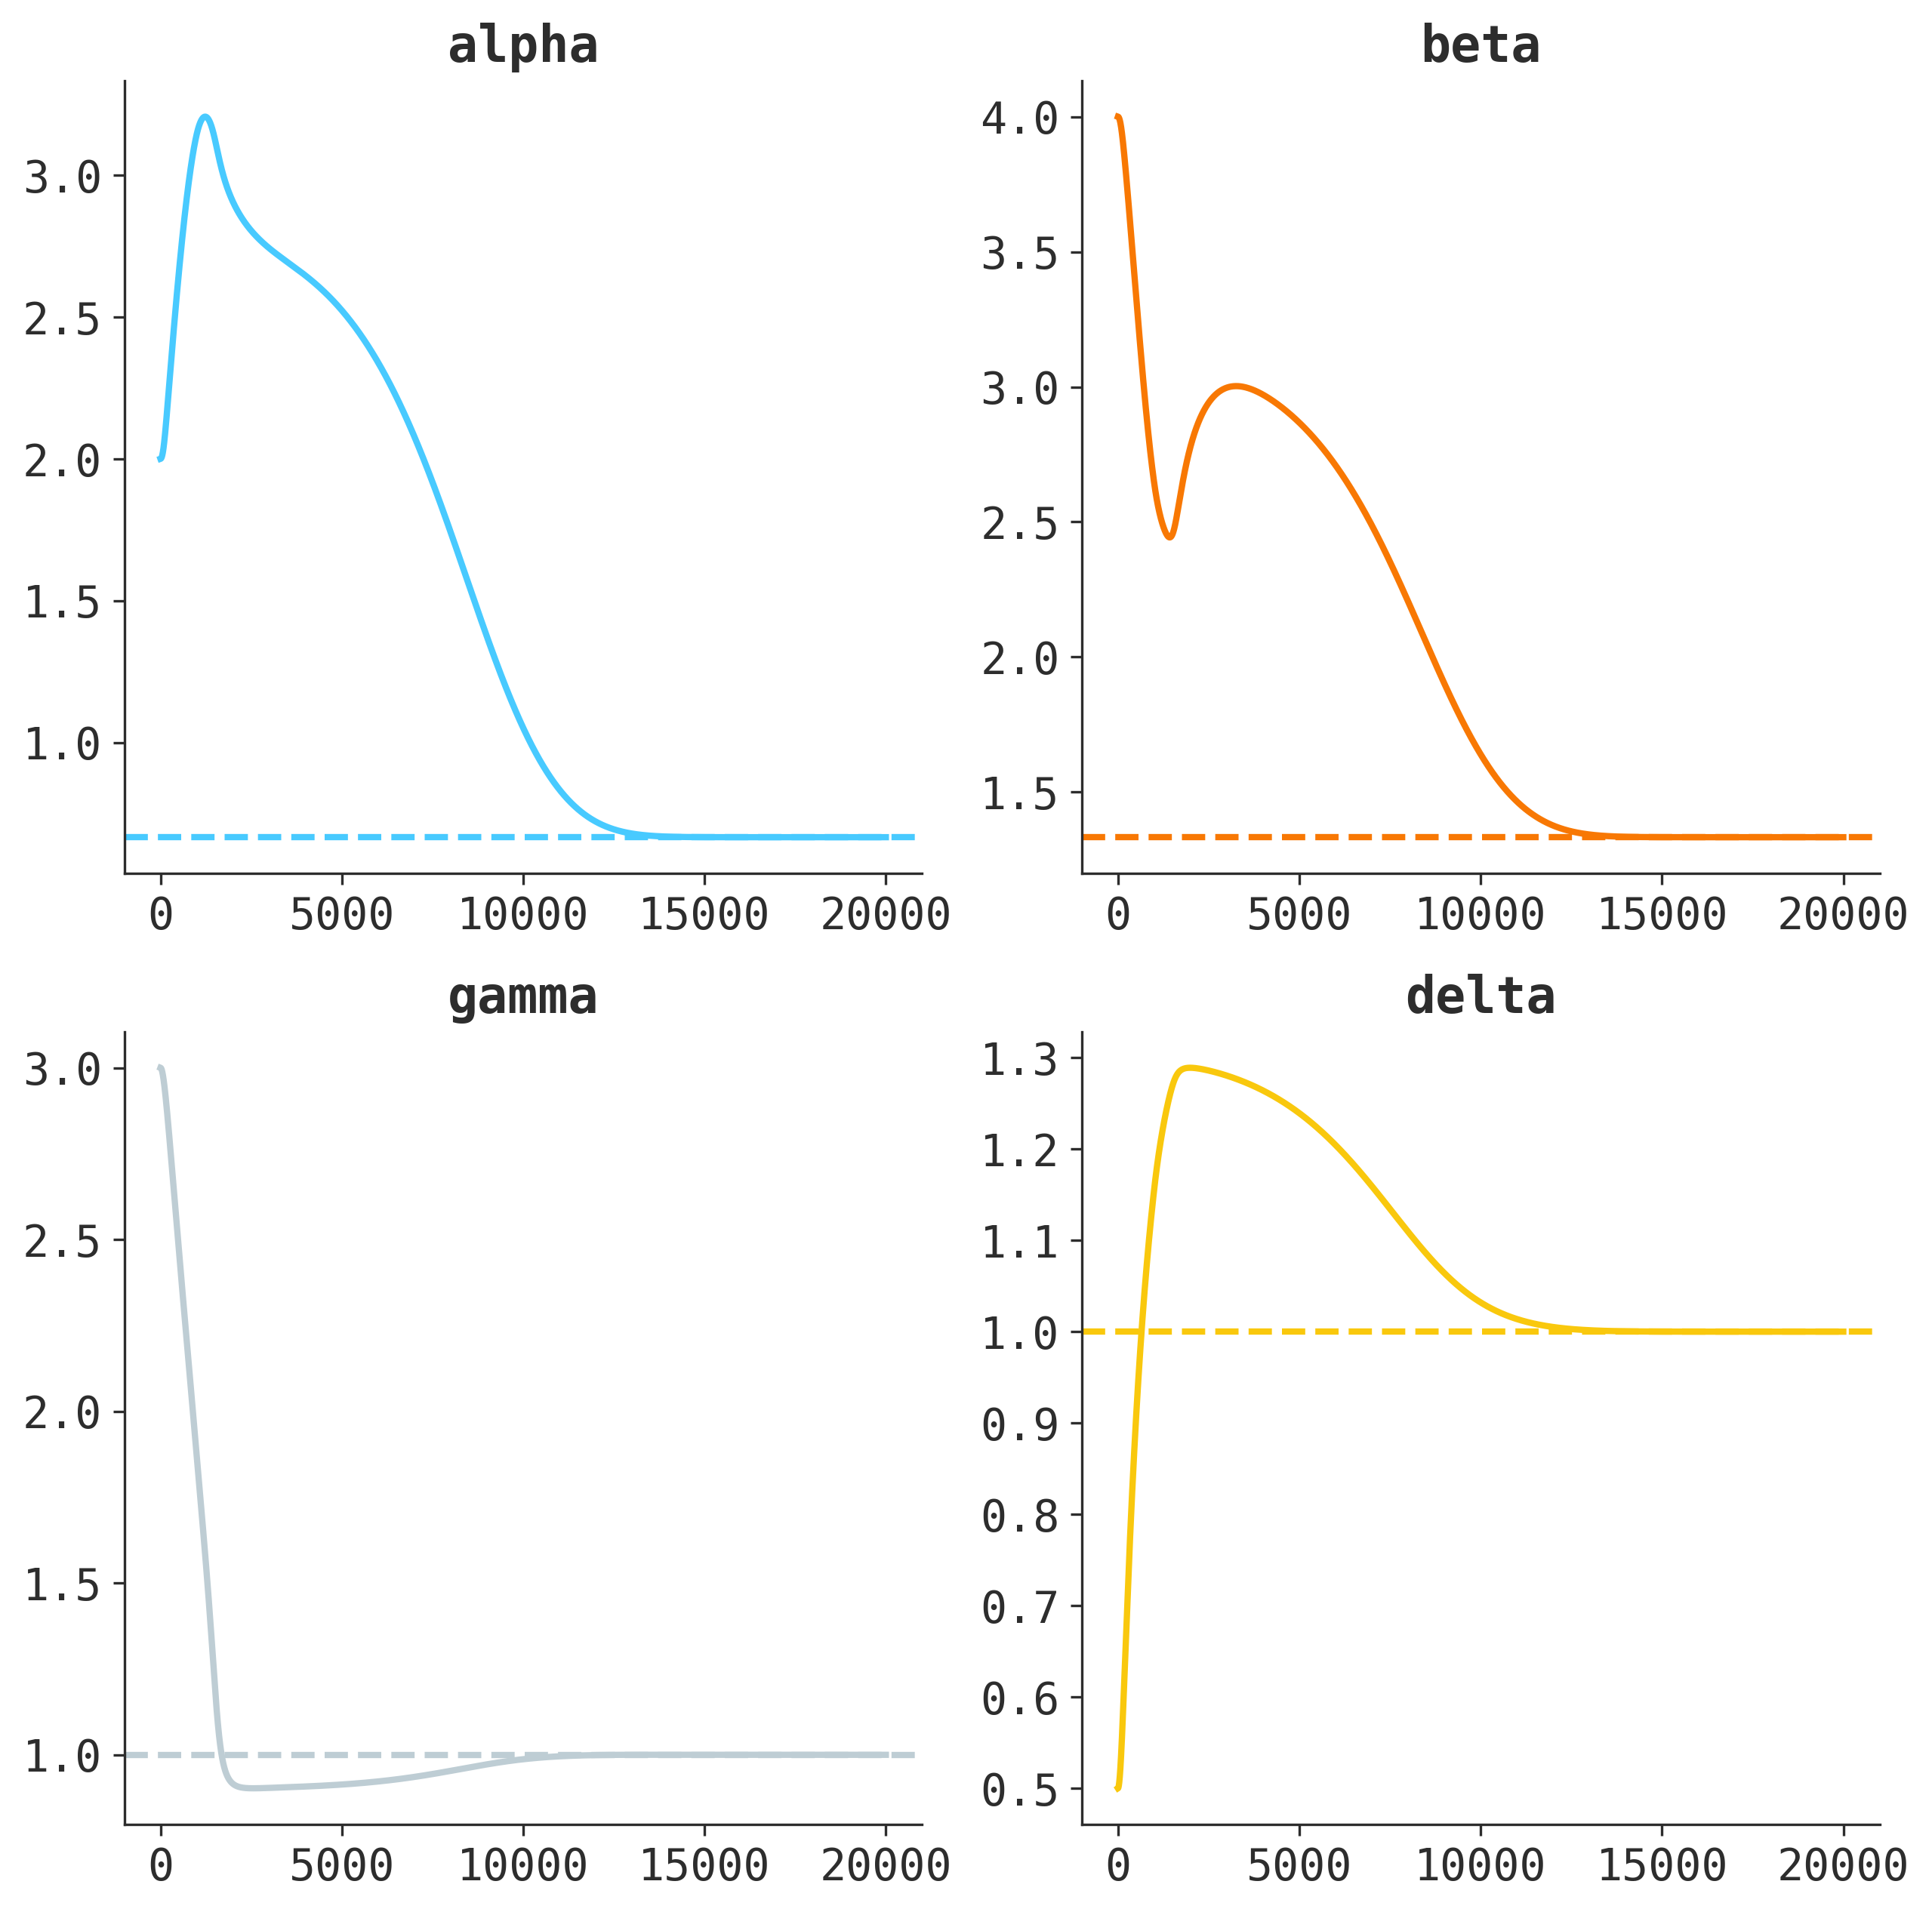

In [121]:
# Let's inspect the parameters
params_history_array = jnp.array([[p.alpha, p.beta, p.gamma, p.delta] for p in params_history])
parameter_names = ["alpha", "beta", "gamma", "delta"]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

axs = ax.flatten()

for i, param in enumerate(parameter_names):
    axs[i].plot(params_history_array[:, i], color=f"C{i}")
    axs[i].axhline(true_params[param], color=f"C{i}", linestyle="--")
    axs[i].set_title(f"{param}")

plt.show()

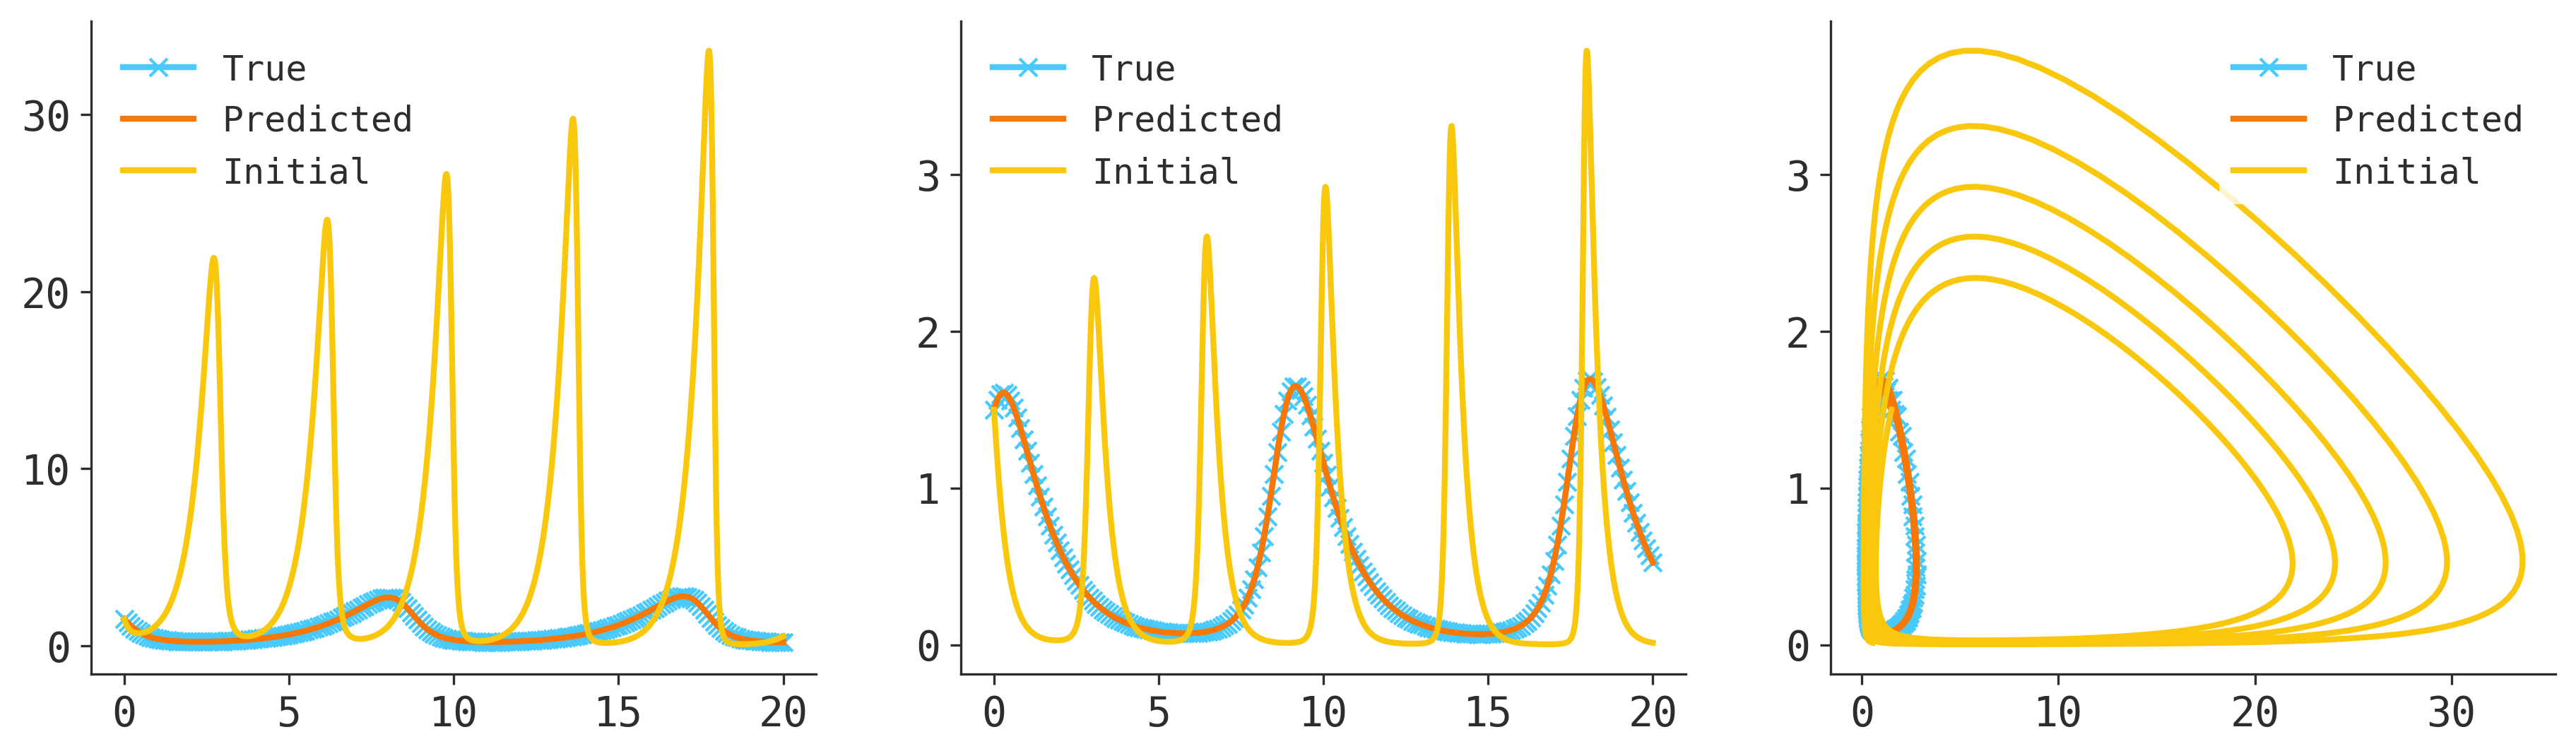

In [125]:
# True trajectory vs predicted trajectory
# Run the model with the best parameters
initial_params = params_history[0]
best_params = params_history[-1]

x, y = lotka_volterra(x_0, y_0, best_params, dt=0.01, n_steps=n_time_steps)
# Stack the predictions into a single array
predictions = jnp.stack([x, y], axis=0)

x_initial, y_initial = lotka_volterra(x_0, y_0, initial_params, dt=0.01, n_steps=n_time_steps)
initial_predictions = jnp.stack([x_initial, y_initial], axis=0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Time series - x
ax[0].plot(data["time"][::10], data["x_true"][::10], color="C0", label="True", marker="x")
ax[0].plot(data["time"], predictions[0], color="C1", label="Predicted")
ax[0].plot(data["time"], initial_predictions[0], color="C3", label="Initial")
ax[0].legend()

# Time series - y
ax[1].plot(data["time"][::10], data["y_true"][::10], color="C0", label="True", marker="x")
ax[1].plot(data["time"], predictions[1], color="C1", label="Predicted")
ax[1].plot(data["time"], initial_predictions[1], color="C3", label="Initial")
ax[1].legend()

# Phase diagram
ax[2].plot(data["true_trajectory"][0][::10], data["true_trajectory"][1][::10], color="C0", label="True", marker="x")
ax[2].plot(predictions[0], predictions[1], color="C1", label="Predicted")
ax[2].plot(initial_predictions[0], initial_predictions[1], color="C3", label="Initial")
ax[2].legend()
plt.show()
